## Evaluate a solution on IBM hardware

In [1]:
from qiskit.opflow import X, Y, Z, I
from qiskit import QuantumCircuit
from qiskit.opflow import CircuitStateFn,PauliExpectation,CircuitSampler
from qiskit.opflow import StateFn,PauliTrotterEvolution,Suzuki
from qiskit.providers.aer import AerSimulator
from qiskit.utils import QuantumInstance 
from qiskit_ibm_provider import IBMProvider
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
import numpy as np
from qiskit_ibm_runtime import QiskitRuntimeService
import matplotlib.pyplot as plt
from qiskit import Aer


/tmp/ipykernel_61/1520645241.py:1: DeprecationWarning: The ``qiskit.opflow`` module is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  from qiskit.opflow import X, Y, Z, I


In [2]:
# The first time, you need to save your credentials on disk
# The API token is a long string that can be found on your IBM Quantum account

#IBMProvider.save_account(token='<IBM Quantum API key>')

In [3]:
# Set your provider instance.
# For the free account, the following line should work
provider = IBMProvider(instance='ibm-q/open/main')

# You can check your available devices/simulators:
print(provider.backends())

[<IBMBackend('ibmq_belem')>, <IBMBackend('simulator_mps')>, <IBMBackend('simulator_statevector')>, <IBMBackend('ibmq_manila')>, <IBMBackend('ibmq_jakarta')>, <IBMBackend('ibm_lagos')>, <IBMBackend('ibm_perth')>, <IBMBackend('ibmq_qasm_simulator')>, <IBMBackend('ibmq_quito')>, <IBMBackend('ibmq_lima')>, <IBMBackend('simulator_extended_stabilizer')>, <IBMBackend('simulator_stabilizer')>, <IBMBackend('ibm_nairobi')>]


In [4]:
# Let's choose a random 7-qubit device. You can choose another
backend_name = "ibm_perth"
backend = provider.get_backend(backend_name, instance='ibm-q-research-2/uni-milano-bicoc-1/main')

# Now we define a QuantumInstance object, in which we specify the number of times we want to run the circuit (shots)
# If this number is too low, we have big statistical fluctuation. If it's too high, we still have systematics due to noise and the process is slower.
q_instance = QuantumInstance(backend, shots=2000)

# Now we define a sampler object
sampler = CircuitSampler(q_instance)

/tmp/ipykernel_61/2175173762.py:7: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  q_instance = QuantumInstance(backend, shots=2000)
/tmp/ipykernel_61/2175173762.py:10: DeprecationWarning: The class ``qiskit.opflow.converters.circuit_sampler.CircuitSampler`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  sampler = CircuitSampler(q_instance)


In [5]:
native_gates = backend.configuration().basis_gates
print(native_gates)

['cx', 'id', 'rz', 'sx', 'x']


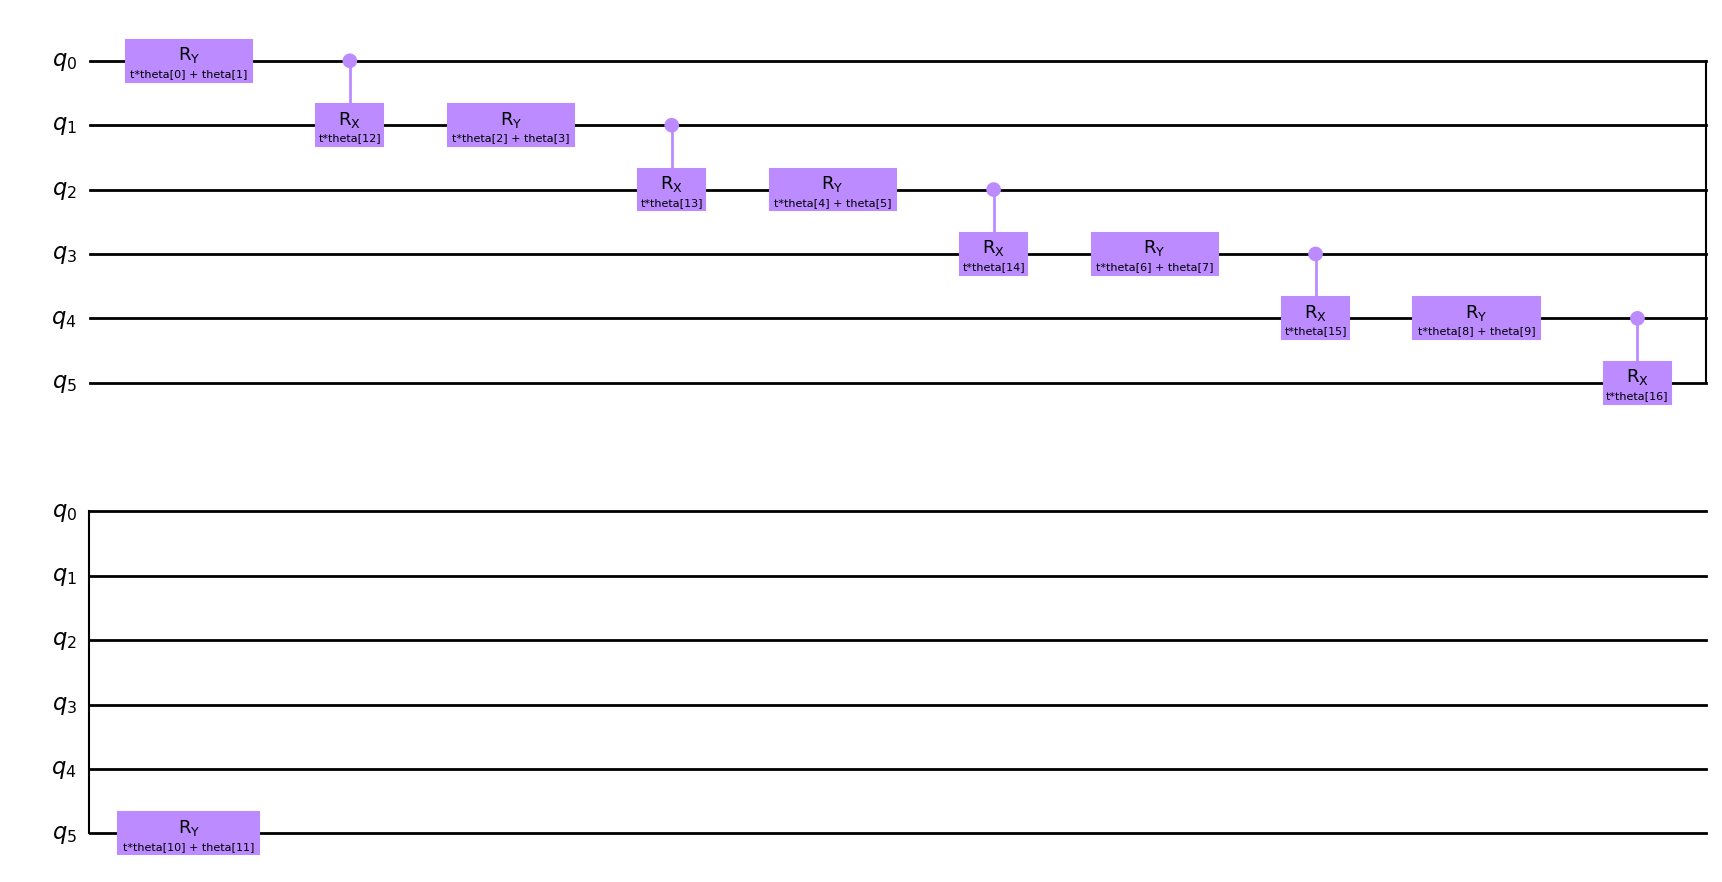

In [6]:
# Let's define the circuit we want to test. I'm defining a random circuit, you can modify this
theta = ParameterVector("theta", 17)
t = Parameter("t")

op = Z^Z^Z^Z^Z^Z
psi = QuantumCircuit(6)

psi.ry(theta[0]*t+ theta[1], 0)
psi.crx(theta[12]*t,0,1)
psi.ry(theta[2]*t+ theta[3], 1)
psi.crx(theta[13]*t,1,2)
psi.ry(theta[4]*t+ theta[5], 2)
psi.crx(theta[14]*t,2,3)
psi.ry(theta[6]*t+ theta[7], 3)
psi.crx(theta[15]*t,3,4)
psi.ry(theta[8]*t+ theta[9], 4)
psi.crx(theta[16]*t,4,5)
psi.ry(theta[10]*t+ theta[11], 5)
psi.draw('mpl')

[0.29904865, 0.18139089, 0.17993054, 0.197327, 0.58606573, -0.26180599, 0.28410509, 0.11913297, 0.22506643, 0.09970065, 0.23561782, 0.07704035, 0.55268409, 0.2573991, 0.47801607, 0.31228026, 0.1790344] 0.8801246 -0.01067926


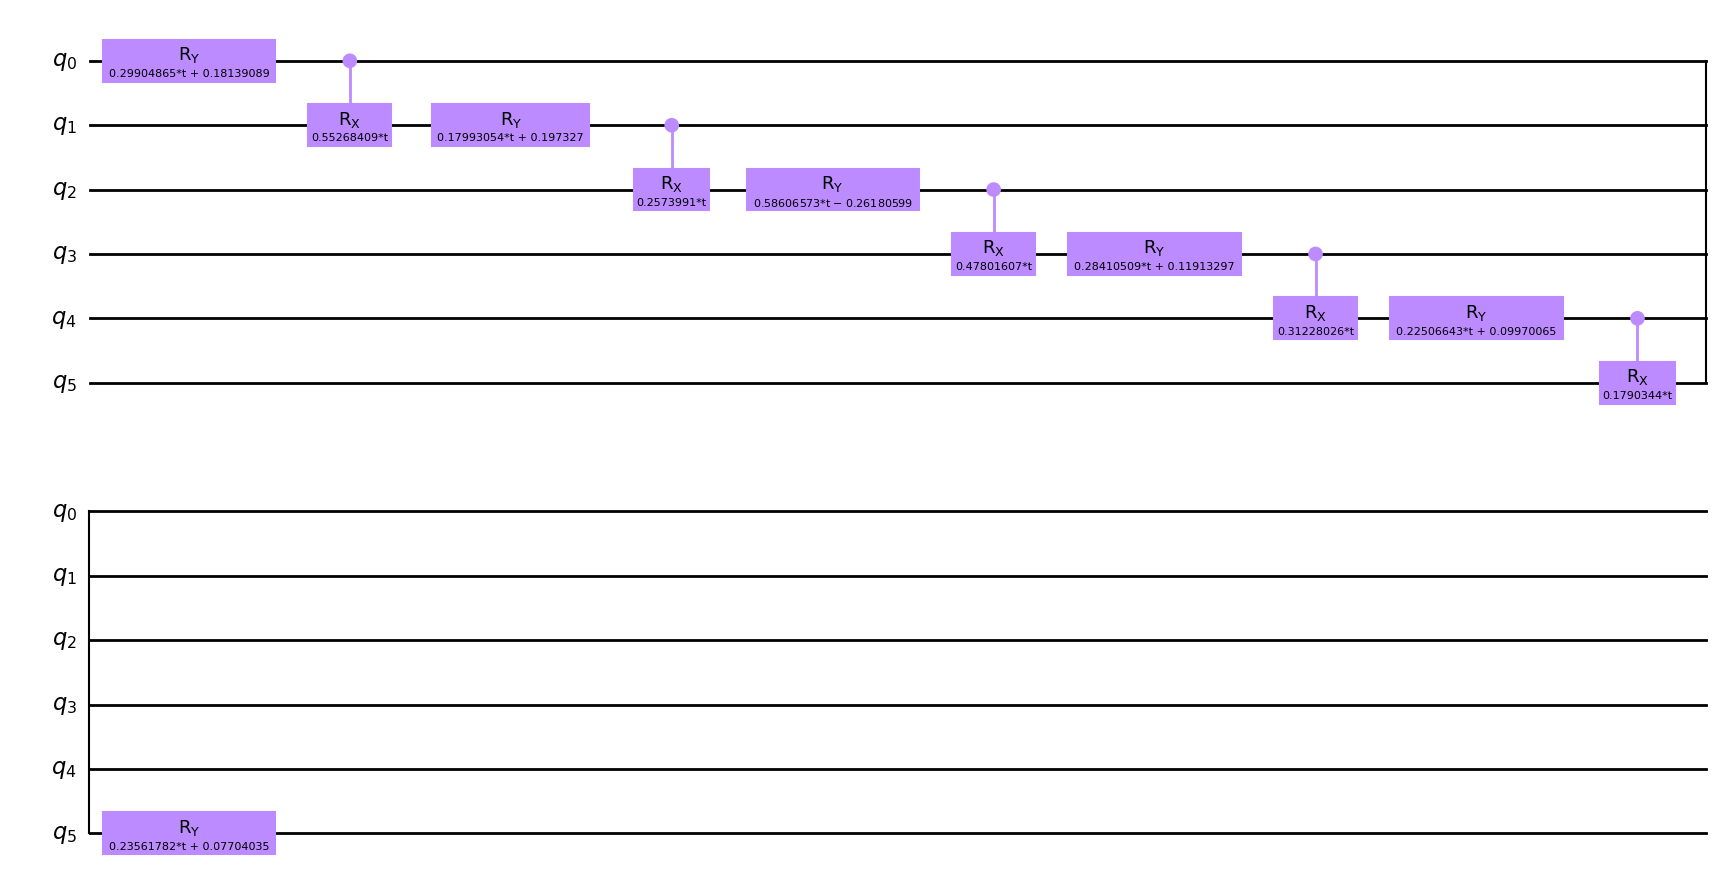

In [7]:
# We need to fix the parameter theta, that here we call 'weights'. Load the thetas already optimized for your circuits 
best_param = [ 0.29904865,  0.18139089,  0.17993054,  0.197327,  0.58606573, -0.26180599, 0.28410509,  0.11913297,  0.22506643 , 0.09970065 , 0.23561782,  0.07704035 , 0.55268409 , 0.2573991,   0.47801607 , 0.31228026 , 0.1790344 ,  0.8801246, -0.01067926]
weights = best_param[:-2]
psi_bounded_theta = psi.assign_parameters({ theta:weights})
scale_param = best_param[-2]
offset_param = best_param[-1]
print(weights,scale_param,offset_param)
psi_bounded_theta.draw('mpl')

In [8]:
# At the moment, for hardware implementation, we define f(t) in a slightly different (completely equivalent) way:
obs = StateFn(op).adjoint() # let Qiskit consider this as the observable

/tmp/ipykernel_61/610533212.py:2: DeprecationWarning: The class ``qiskit.opflow.state_fns.operator_state_fn.OperatorStateFn`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  obs = StateFn(op).adjoint() # let Qiskit consider this as the observable


In [ ]:
# for 50 points in a time interval we evaluate f(t) with a separate job. This can take a lot of time as you are waiting the device to run youy 50 jobs.
tgrid = np.linspace(0, 2*np.pi, 50)
f = np.zeros(len(tgrid))
for i, time in enumerate(tgrid):
    psi_all_bounded = psi_bounded_theta.assign_parameters({t:time})
    psi_all_bounded = CircuitStateFn(psi_all_bounded)
    measurable_expression = obs @ psi_all_bounded
    expectation = PauliExpectation().convert(measurable_expression)
    sampled_exp_op = sampler.convert(expectation) 
    f[i] = scale_param*sampled_exp_op.eval().real + offset_param

/tmp/ipykernel_62/3241790032.py:6: DeprecationWarning: The class ``qiskit.opflow.state_fns.circuit_state_fn.CircuitStateFn`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  psi_all_bounded = CircuitStateFn(psi_all_bounded)
/tmp/ipykernel_62/3241790032.py:8: DeprecationWarning: The class ``qiskit.opflow.expectations.pauli_expectation.PauliExpectation`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  expectation = PauliExpectation().convert(measurable_expression)


In [9]:
# from qiskit.result import sampled_expectation_value

# provider = IBMProvider(instance='ibm-q/open/main')
# jobs = provider.backend.jobs(status='DONE',limit=50,start_datetime='2023-06-27T22:00:00.000Z',end_datetime='2023-06-30T22:00:00.000Z')



In [ ]:
# f = np.zeros(50)

# obss = Z^Z^Z^Z^Z^Z
# for i in np.arange(44)[0:]:
#     counts = jobs[-i].result().get_counts()
#     #print(counts)
    
#     f[i] = scale_param * sampled_expectation_value(counts,obss) + offset_param
# print(f)

[ 0.54203899  0.56140173  0.35369232  0.38185631  0.28680285  0.28680285
  0.33080908  0.2885631   0.27360099  0.22431401  0.16182516  0.15038354
  0.12574005  0.17414691  0.06765183  0.09493569  0.0271661   0.0166046
  0.04476859 -0.00539851  0.03508722  0.04124809 -0.00715876  0.01220398
  0.01044373  0.0306866  -0.00715876  0.02980647  0.05709033 -0.0335625
 -0.04148362  0.0271661  -0.01596001 -0.07140786  0.01572448 -0.02740163
  0.02100523  0.00516298  0.0236456   0.02980647 -0.02124076 -0.00099789
  0.03332697 -0.04764449  0.          0.          0.          0.
  0.          0.        ]


In [11]:
# let's quickly compare the results with the simulated backend
backend = Aer.get_backend('statevector_simulator')
q_instance = QuantumInstance(backend, shots=2000)
tgrid = np.linspace(0, 2*np.pi, 50)
# Now we define a sampler object
sampler = CircuitSampler(q_instance)
f_ideal = np.zeros(len(tgrid))
for i, time in enumerate(tgrid):
    psi_all_bounded = psi_bounded_theta.assign_parameters({t:time})
    psi_all_bounded = CircuitStateFn(psi_all_bounded)
    measurable_expression = obs @ psi_all_bounded
    expectation = PauliExpectation().convert(measurable_expression)
    sampled_exp_op = sampler.convert(expectation) 
    #print(sampled_exp_op.eval().real)
    f_ideal[i] = scale_param * sampled_exp_op.eval() + offset_param

/tmp/ipykernel_61/2554684112.py:3: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  q_instance = QuantumInstance(backend, shots=2000)
/tmp/ipykernel_61/2554684112.py:6: DeprecationWarning: The class ``qiskit.opflow.converters.circuit_sampler.CircuitSampler`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  sampler = CircuitSampler(q_instance)
/tmp/ipykernel_61/2554684112.py:10: DeprecationWarning: The class ``qiskit.opflow.state_fns.circuit_state_fn.CircuitStateFn`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  psi_a

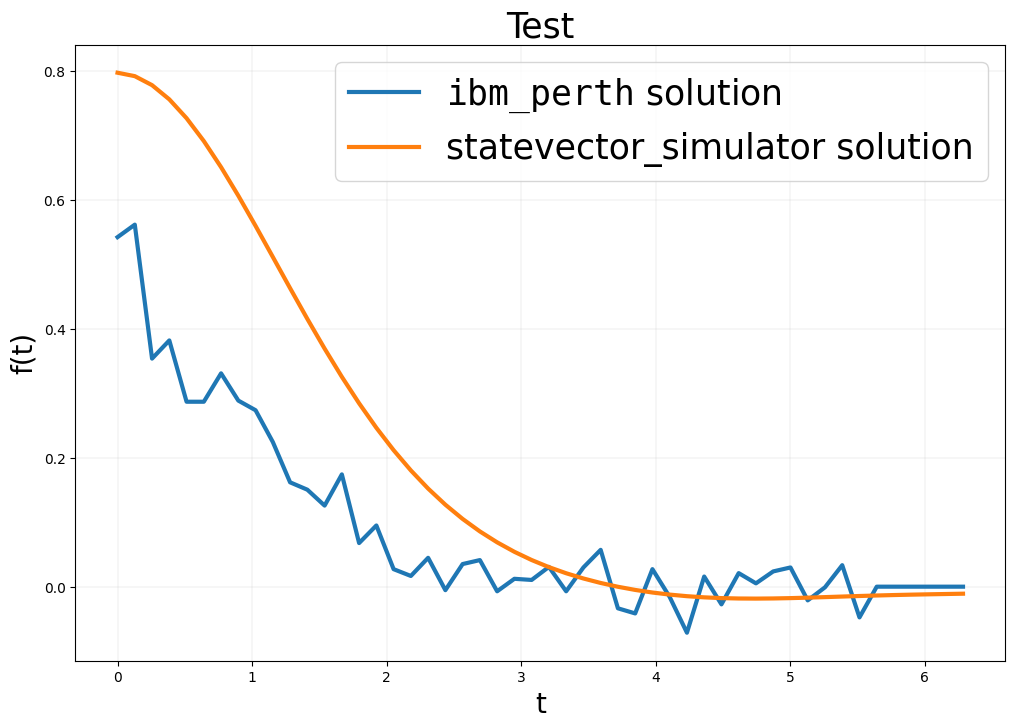

In [12]:
# plot the results. You can also compute the circuit with statevector (as we always did) and plot it aswell for reference
fig = plt.figure(figsize=(12,8))
#plt.rcParams['font.family'] = 'Times New Roman'
plt.plot(tgrid, f,linewidth=3,label=r'$\tt ibm\_perth$ solution')
plt.plot(tgrid, f_ideal,linewidth=3,label="statevector_simulator solution")
plt.grid(True, linewidth=0.15)
plt.title("Test",fontsize=25)
plt.xlabel("t",fontsize=20)
plt.ylabel("f(t)",fontsize=20)
plt.legend(fontsize=25)